In [1]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.feature_selection import *
import seaborn as sns
from scipy import stats
import warnings
from numpy import median
from matplotlib.pyplot import cm
warnings.filterwarnings('ignore')

In [2]:
def regPlots(df,x,y,col,row,ylim=None,color='#ff7f03',fsize=[12,4],xlim=None,yerrd=np.array([None,None])):
    plt.figure(figsize=fsize)
    c = 1
    row_ls = list(set(df[row]))
    col_ls = list(set(df[col]))
    nRow = len(row_ls)
    nCol = len(col_ls)
    for i in range(nRow):
        for j in range(nCol):
            ax = plt.subplot(nRow,nCol,c)
            d = df.loc[(df[col]==col_ls[j])&(df[row]==row_ls[i])]
            #sns.regplot(x=x,y=y,data=d,ci=None,color=color,scatter_kws={'facecolors':d['color'],'edgecolors':d['color']},fit_reg=False) #blue '#1f77b4'
            #for cc in set(d.color):
            #    plt.plot(d.loc[d.color==cc][x],d.loc[d.color==cc][y],marker='.',linestyle='-',color=cc)
            sns.lineplot(data=d, x=x, y=y, hue="topology", markers=["o","*",">","<","."], ci=None, style='topology', dashes=False)
            
            if all(yerrd != None):
                yerr = []
                x_e = []
                y_e = []
                for tpl in d["topology"]:
                    for k in set(d["nNode"]):
                        yerr.append(yerrd.loc[(yerrd[col]==col_ls[j])&(yerrd[row]==row_ls[i])&(yerrd.nNode==k)&(yerrd.topology==tpl)][y].std())
                        x_e.append(d.loc[(d.nNode==k)&(d.topology==tpl)][x].mean())
                        y_e.append(d.loc[(d.nNode==k)&(d.topology==tpl)][y].mean())
                    ax.errorbar(x_e, y_e, yerr=yerr, fmt='none', capsize=5, zorder=1, color='grey')
                    
            plt.legend(bbox_to_anchor=(1.1,0.5,1,0.5), loc=2, borderaxespad=0.)
            if ylim != None:
                plt.ylim(ylim)
            else:
                plt.ylim(bottom=0)
            if xlim != None:
                plt.xlim(xlim)
            c += 1
            plt.title(col_ls[j])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.subplots_adjust(wspace=0.7)
    plt.show()

In [3]:
tpl25 = pd.read_table("WL7-4_result_d05/topology_N25_dg",delimiter=' ')
tpl50 = pd.read_table("WL7-4_result_d05/topology_N50_dg",delimiter=' ')
tpl100 = pd.read_table("WL7-4_result_d05/topology_N100_dg",delimiter=' ')
tpl500 = pd.read_table("WL7-4_result_d05/topology_N500_dg",delimiter=' ')
tpl750 = pd.read_table("WL7-4_result_d05/topology_N750_dg",delimiter=' ')

### Full model with c=1

In [4]:
df25 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/c1_2021-Apr-24/Results_WL7-4_5nets_N25e25_h0.1c1.txt",delimiter=' ')
df25 = pd.merge(df25,tpl25,on='NetName')
df50 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/c1_2021-Apr-24/Results_WL7-4_5nets_N50e50_h0.1c1.txt",delimiter=' ')
df50 = pd.merge(df50,tpl50,on='NetName')
df100 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/c1_2021-Apr-24/Results_WL7-4_5nets_N100e100_h0.1c1.txt",delimiter=' ')
df100 = pd.merge(df100,tpl100,on='NetName')
df500 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/c1_2021-Apr-24/Results_WL7-4_5nets_N500e500_h0.1c1.txt",delimiter=' ')
df500 = pd.merge(df500,tpl500,on='NetName')
df750 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/c1_2021-Apr-24/Results_WL7-4_5nets_N750e750_h0.1c1.txt",delimiter=' ')
df750 = pd.merge(df750,tpl750,on='NetName')
df1 = pd.concat([df25,df50,df100,df500,df750],axis=0)
#df1 = pd.merge(df1,tpl,on='NetName')
#df1 = df1.drop(columns=['Com'])
total = len(df1)
df = df1.replace([np.inf, -np.inf],np.nan).dropna()
topology = []
nNode = []
for i in df.NetName:
    name = i.split('_')[1]
    node = i.split('_')[0].split('e')[0].strip('N')
    topology.append(name)
    nNode.append(int(node))
df['topology'] = topology
df['nNode'] = nNode
pd.options.display.max_columns = df.shape[1]
dfall = df.loc[df.tot_biomass!='extinction']

cols=[]
cpalette = sns.color_palette("Set2", 5)

for i in dfall.topology:
    if i == "Complete":
        cols.append(cpalette[0])
    elif i == "Grid":
        cols.append(cpalette[1])
    elif i == "Linear":
        cols.append(cpalette[2])
    elif i == "SmallWorld":
        cols.append(cpalette[3])
    elif i == "Tree":
        cols.append(cpalette[4])
dfall['color'] = cols

In [5]:
# https://people.richland.edu/james/lecture/m170/ch13-1wy.html
data = dfall.loc[(dfall.r_std==1.0)&(dfall.d==0.5)&(dfall.rho_eta_hetero==0.8)&(dfall.rho_eta_fluc==0.95)]
GM = data.mean()[dfall.columns[1:9]]
# total variation
SST = 0
for i in data[data.columns[1:9]].values:
    SST += (i - GM)**2
#SST = data.var(axis=0,ddof=0)[dfall.columns[1:9]]
print('total variation\n', SST)

# between-group variation
SSB = 0
for name in set(data.NetName):
    d = data.loc[data.NetName==name]
    n = len(d)
    SSB += n * (d.mean()[data.columns[1:9]] - GM)**2
print('between-group variation\n',SSB)

# within-group variation
SSW = SST - SSB
print('within-group variation\n',SSW)

#SSW2 = 0
#for name in set(data.NetName):
#    d = data.loc[data.NetName==name]
#    n = len(d)
#    for i in d.values:
#        SSW2 += (i[1:9] - d.mean()[data.columns[1:9]])**2
#print('within-group variation2\n', SSW2)
# this is confirmed to be same as SST - SSB above!


N = len(data)
k = len(set(data.NetName))
MSB = SSB / (k-1)
MSW = SSW / (N-k)
print('F-value\n',MSB/MSW)

total variation
 CVcr      82.825743
CVcl      25.965662
CVsr     537.359944
CVsl     195.864460
phi_r     20.650862
phi_l     11.323976
phi_c    154.005238
phi_s    143.181823
dtype: float64
between-group variation
 CVcr      66.931000
CVcl       9.590791
CVsr     501.792887
CVsl     157.400542
phi_r      0.629475
phi_l      2.580529
phi_c    145.243328
phi_s    138.148304
dtype: float64
within-group variation
 CVcr     15.894743
CVcl     16.374870
CVsr     35.567057
CVsl     38.463918
phi_r    20.021387
phi_l     8.743447
phi_c     8.761911
phi_s     5.033519
dtype: float64
F-value
 CVcr      434.247935
CVcl       60.400501
CVsr     1454.924730
CVsl      422.004093
phi_r       3.242262
phi_l      30.436169
phi_c    1709.469396
phi_s    2830.334584
dtype: float64


### Figure A3(m), (n)

<IPython.core.display.Javascript object>


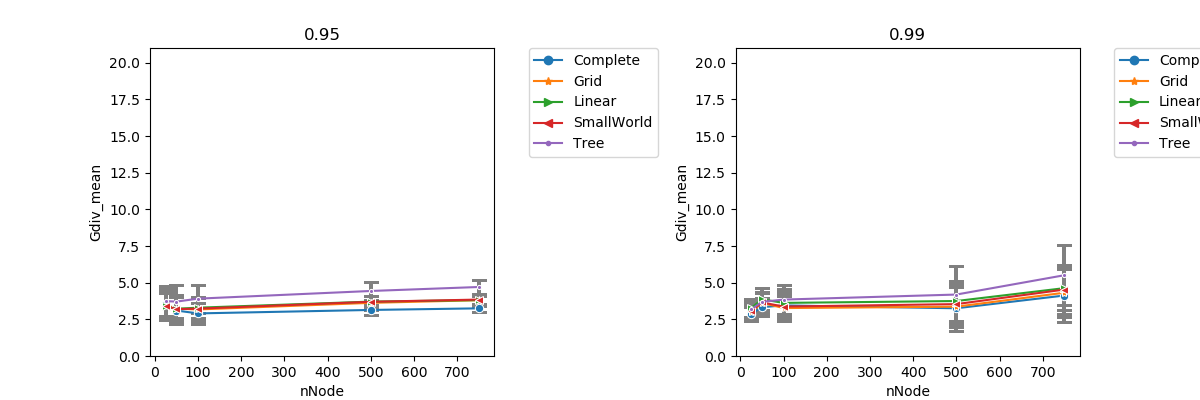

In [6]:
df = dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)]
regPlots(df,"nNode","Gdiv_mean","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,ylim=[0,21])
# left: Figure A3(m)

<IPython.core.display.Javascript object>


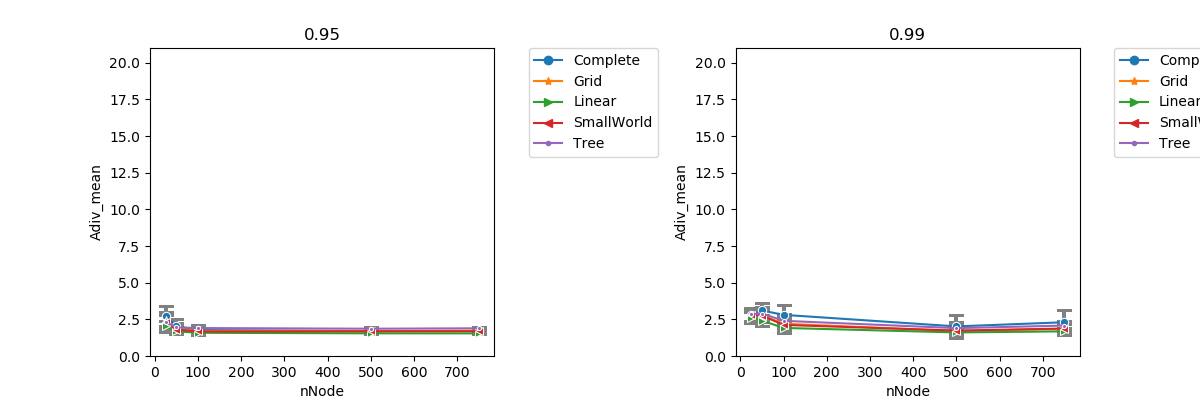

In [7]:
df = dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)]
regPlots(df,"nNode","Adiv_mean","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,ylim=[0,21])
# left: Figure A3(n)

### Figure A3(q), (r)

<IPython.core.display.Javascript object>


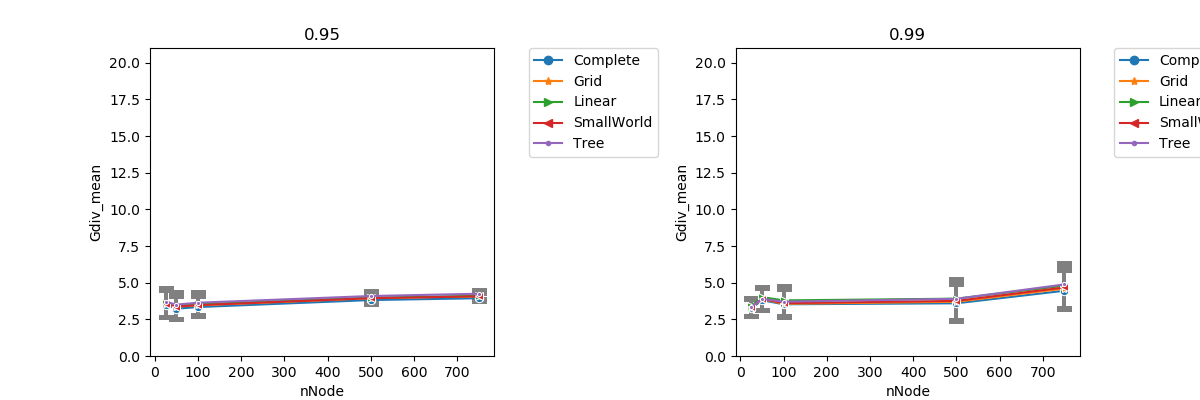

In [8]:
df = dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.05)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.05)]
regPlots(df,"nNode","Gdiv_mean","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,ylim=[0,21])
# left: Figure A3(q)

<IPython.core.display.Javascript object>


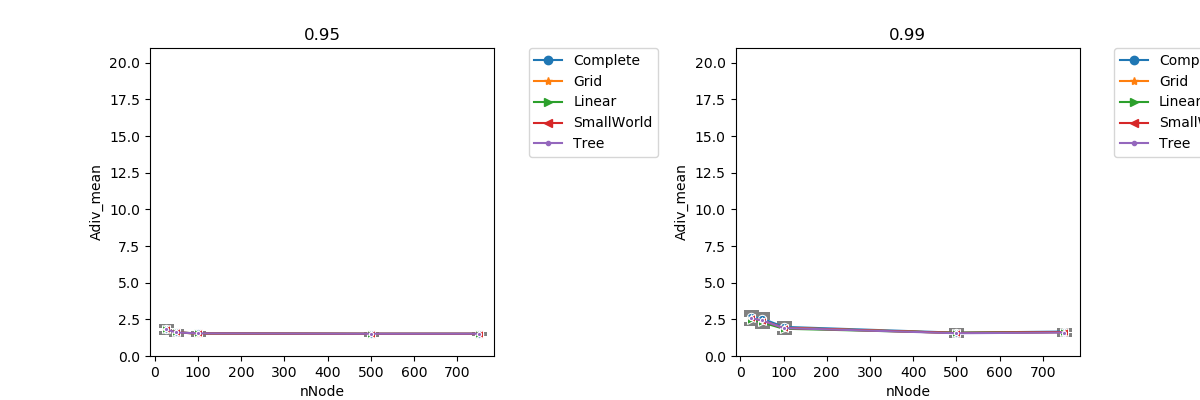

In [9]:
df = dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.05)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.05)]
regPlots(df,"nNode","Adiv_mean","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,ylim=[0,21])
# left: Figure A3(r)

### Full model with c=0

In [10]:
df25 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/Results_WL7-4_5nets_N25e25_h0.1_Im.txt",delimiter=' ')
df25 = pd.merge(df25,tpl25,on='NetName')
df50 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/Results_WL7-4_5nets_N50e50_h0.1_Im.txt",delimiter=' ')
df50 = pd.merge(df50,tpl50,on='NetName')
df100 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/Results_WL7-4_5nets_N100e100_h0.1_Im.txt",delimiter=' ')
df100 = pd.merge(df100,tpl100,on='NetName')
df500 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/Results_WL7-4_5nets_N500e500_h0.1_Im.txt",delimiter=' ')
df500 = pd.merge(df500,tpl500,on='NetName')
df750 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/Results_WL7-4_5nets_N750e750_h0.1_Im.txt",delimiter=' ')
df750 = pd.merge(df750,tpl750,on='NetName')
df1 = pd.concat([df25,df50,df100,df500,df750],axis=0)
#df1 = pd.merge(df1,tpl,on='NetName')
#df1 = df1.drop(columns=['Com'])
total = len(df1)
df = df1.replace([np.inf, -np.inf],np.nan).dropna()
topology = []
nNode = []
for i in df.NetName:
    name = i.split('_')[1]
    node = i.split('_')[0].split('e')[0].strip('N')
    topology.append(name)
    nNode.append(int(node))
df['topology'] = topology
df['nNode'] = nNode
pd.options.display.max_columns = df.shape[1]
dfall_c0 = df.loc[df.tot_biomass!='extinction']

cols=[]
cpalette = sns.color_palette("Set2", 5)

for i in dfall_c0.topology:
    if i == "Complete":
        cols.append(cpalette[0])
    elif i == "Grid":
        cols.append(cpalette[1])
    elif i == "Linear":
        cols.append(cpalette[2])
    elif i == "SmallWorld":
        cols.append(cpalette[3])
    elif i == "Tree":
        cols.append(cpalette[4])
dfall_c0['color'] = cols

### Figure A3(a), (b)

<IPython.core.display.Javascript object>


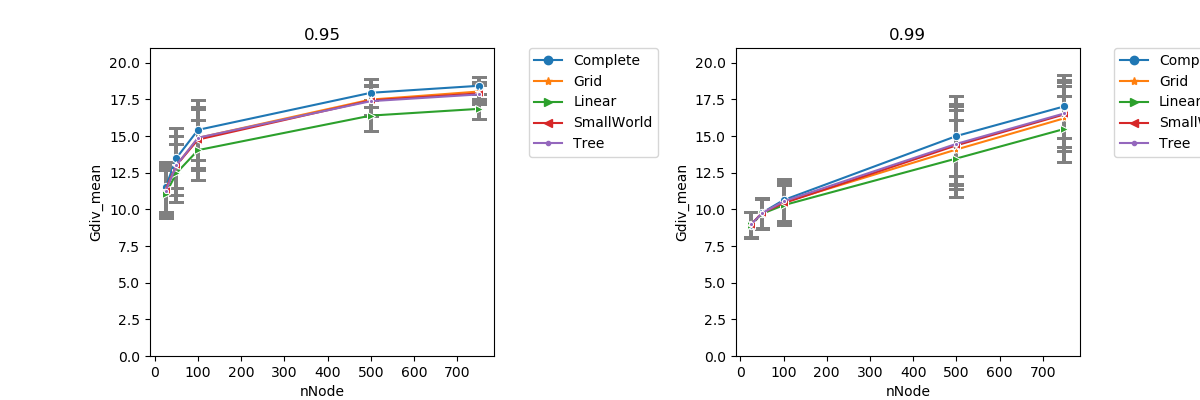

In [11]:
df = dfall_c0.loc[(dfall_c0.r_std==1.0)&(dfall_c0.rho_eta_hetero==0.8)&(dfall_c0.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall_c0.loc[(dfall_c0.r_std==1.0)&(dfall_c0.rho_eta_hetero==0.8)&(dfall_c0.d==0.5)]
regPlots(df,"nNode","Gdiv_mean","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,ylim=[0,21])
# left: Figure A3(a)

<IPython.core.display.Javascript object>


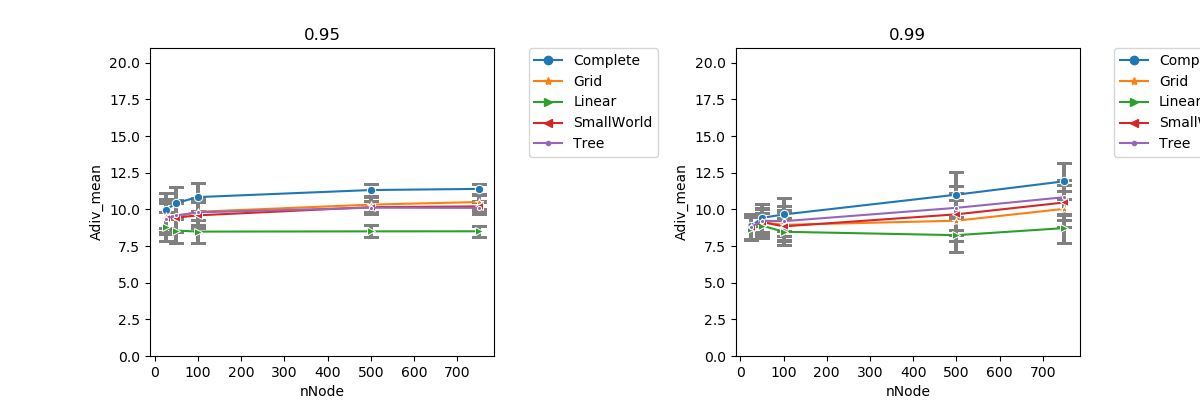

In [12]:
df = dfall_c0.loc[(dfall_c0.r_std==1.0)&(dfall_c0.rho_eta_hetero==0.8)&(dfall_c0.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall_c0.loc[(dfall_c0.r_std==1.0)&(dfall_c0.rho_eta_hetero==0.8)&(dfall_c0.d==0.5)]
regPlots(df,"nNode","Adiv_mean","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,ylim=[0,21])
# left: Figure A3(b)